# Stanford CME 241 (Winter 2026) - Assignment 2

**Due: Friday, February 13 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/onat-dalmaz/RL-book/blob/main/Assignments/Assignment%202/assignment2.ipynb

*Group members (replace below names with people in your group):* 
- Onat Dalmaz

## Imports

In [4]:
import math
import itertools
import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Tuple, List, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Ensure RL-book repo root is on path (for Q2: FiniteMarkovDecisionProcess, value_iteration)
def _add_repo_root() -> None:
    p = Path.cwd()
    while p != p.parent and not (p / "rl").is_dir():
        p = p.parent
    if (p / "rl").is_dir() and str(p) not in sys.path:
        sys.path.insert(0, str(p))
_add_repo_root()

plt.rcParams["figure.figsize"] = (8, 4)


## Question 1: Job-Hopping and Wages-Utility-Maximization (Led by Onat Dalmaz)

You are a worker who starts every day either employed or unemployed. If you start your day employed, you work on your job for the day (one of $n$ jobs, as elaborated later) and you get to earn the wage of the job for the day. However, at the end of the day, you could lose your job with probability $\alpha \in [0,1]$, in which case you start the next day unemployed. If at the end of the day, you do not lose your job (with probability $1-\alpha$), then you will start the next day with the same job (and hence, the same daily wage). 

On the other hand, if you start your day unemployed, then you will be randomly offered one of $n$ jobs with daily wages $w_1, w_2, \ldots w_n \in \mathbb{R}^+$ with respective job-offer probabilities $p_1, p_2, \ldots p_n \in [0,1]$ (with $\sum_{i=1}^n p_i = 1$). You can choose to either accept or decline the offered job. If you accept the job offer, your day progresses exactly like the **employed-day** described above (earning the day's job wage and possibly (with probability $\alpha$) losing the job at the end of the day). However, if you decline the job offer, you spend the day unemployed, receive the unemployment wage $w_0 \in \mathbb{R}^+$ for the day, and start the next day unemployed.

The problem is to identify the optimal choice of accepting or rejecting any of the job offers the worker receives, in a manner that maximizes the infinite-horizon **Expected Discounted-Sum of Wages Utility**. Assume the daily discount factor for wages (employed or unemployed) is $\gamma \in [0,1])$. Assume Wages Utility function to be $U(w) = \log(w)$ for any wage amount $w \in \mathbb{R}^+$. The goal is to maximize:

$$
\mathbb{E}\left[\sum_{u=t}^\infty \gamma^{u-t} \cdot \log(w_{i_u})\right]
$$

at the start of a given day $t$ ($w_{i_u}$ is the wage earned on day $u$, $0 \leq i_u \leq n$ for all $u \geq t$).

---

### Subquestions

#### Part (A): MDP Modeling

Express the job-hopping problem as an MDP using clear mathematical notation by defining the following components:

1. **State Space**: Define the possible states of the MDP.
2. **Action Space**: Specify the actions available to the worker at each state.
3. **Transition Function**: Describe the probabilities of transitioning between states for each action.
4. **Reward Function**: Specify the reward associated with the states and transitions.
5. **Bellman Optimality Equation**: Write the Bellman Optimality Equation customized for this MDP.

---

#### Part (B): Python Implementation

Write Python code that:

1. Solves the Bellman Optimality Equation (hence, solves for the **Optimal Value Function** and the **Optimal Policy**) with a numerical iterative algorithm. 
2. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

*Note*: For this problem, write the algorithm from scratch without using any prebuilt MDP/DP libraries or code.

---

#### Part (C): Visualization and Analysis

1. Plot the **Optimal Value Function** as a function of the state for a specific set of parameters ($n$, $w_1, \ldots, w_n$, $p_1, \ldots, p_n$, $\alpha$, $\gamma$, $w_0$).
2. Include these graphs in your submission.

---

#### Part (D): Observations

1. What patterns do you observe in the **Optimal Policy** as you vary the parameters $n$, $\alpha$, and $\gamma$?
2. Provide a brief discussion of your findings.

---

### Part (A) Answer

Let wages be $w_0$ (unemployment income) and offered wages $w_1 < w_2 < \dots < w_n$ with offer probabilities $p_1,\dots,p_n$ (\(\sum_i p_i = 1\)). Let $\alpha$ be the per-day job-loss probability and $\gamma\in[0,1)$ the discount.

A clean finite MDP is obtained by **including the offer in the state**.

**States**
- Unemployed-with-offer: $U_i$ = “unemployed at start of day, offered job $i$”.
- Employed: $E_i$ = “employed in job $i$ at start of day”.
So $\mathcal S = \{U_1,\dots,U_n, E_1,\dots,E_n\}$ (size $2n$).

**Actions**
- In $U_i$: $\mathcal A(U_i)=\{\texttt{accept},\texttt{reject}\}$.
- In $E_i$: $\mathcal A(E_i)=\{\texttt{keep}\}$ (no decision).

**Rewards**
Daily utility is log-utility of that day’s income:
- If you work job $i$: $r(s,a)=\log w_i$.
- If you are unemployed (reject offer): $r(s,a)=\log w_0$.

**Transitions**
Let $\bar U$ denote “tomorrow unemployed with a fresh offer”, i.e. a draw from $\{U_j\}$ with probs $p_j$.

- From $U_i$:
  - If **reject**: tomorrow is unemployed with a new offer:
    $$P(U_j\mid U_i,\texttt{reject})=p_j.$$
  - If **accept**: you work job $i$ today, and tomorrow:
    - with prob $1-\alpha$: still employed in job $i$,
    - with prob $\alpha$: job ends and you’re unemployed with a new offer.
    $$P(E_i\mid U_i,\texttt{accept})=1-\alpha,\qquad P(U_j\mid U_i,\texttt{accept})=\alpha p_j.$$

- From $E_i$ (forced keep): identical continuation:
  $$P(E_i\mid E_i,\texttt{keep})=1-\alpha,\qquad P(U_j\mid E_i,\texttt{keep})=\alpha p_j.$$

This fully specifies $(\mathcal S,\mathcal A, P, r, \gamma)$.

**Bellman optimality equations (customized to this MDP)**  
Let $V(s)$ denote the optimal value function.

- For employed states (no choice):
$$
V(E_i)=\log w_i+\gamma\Big[(1-\alpha)V(E_i)+\alpha\sum_{j=1}^n p_j V(U_j)\Big].
$$
Equivalently, solving for $V(E_i)$:
$$
V(E_i)=\frac{\log w_i+\gamma\alpha\sum_{j=1}^n p_j V(U_j)}{1-\gamma(1-\alpha)}.
$$

- For unemployed-with-offer states (accept/reject choice):
$$
V(U_i)=\max\Big\{
\underbrace{\log w_0+\gamma\sum_{j=1}^n p_j V(U_j)}_{\text{reject}},
\underbrace{\log w_i+\gamma\big[(1-\alpha)V(E_i)+\alpha\sum_{j=1}^n p_j V(U_j)\big]}_{\text{accept}}
\Big\}.
$$


### Part (B) Answer

Below is a self-contained value-iteration implementation for this finite MDP, plus a plot of the optimal value function and the resulting accept/reject policy over wage offers.


Optimal accept decisions by offered wage:
  offer w=1.05: reject
  offer w=1.10: reject
  offer w=1.20: reject
  offer w=1.35: reject
  offer w=1.60: accept
  offer w=2.00: accept

Reservation wage ≈ 1.60 (accept all offers >= this)


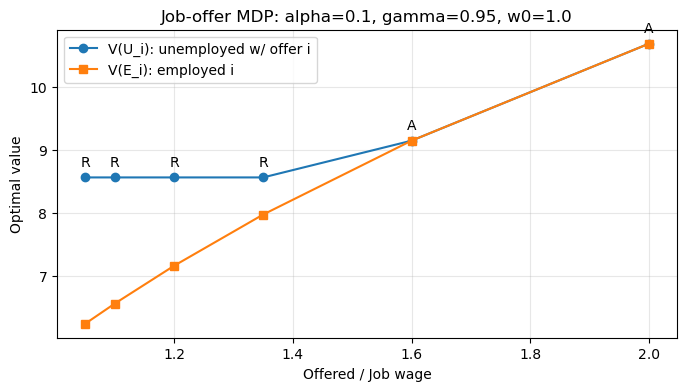

In [5]:
# --- Q1(B): Value Iteration for the Job-Offer MDP ---

def build_job_offer_mdp(
    wages: List[float],          # [w1,...,wn]
    p: List[float],              # [p1,...,pn]
    w0: float,
    alpha: float,
):
    """
    Returns:
      states: list of state labels
      actions: dict[state] -> list[action]
      transitions: dict[(state, action)] -> list[(prob, next_state, reward)]
    """
    n = len(wages)
    assert len(p) == n
    assert abs(sum(p) - 1.0) < 1e-8

    states = []
    for i in range(n):
        states.append(("U", i))  # unemployed, offered job i
    for i in range(n):
        states.append(("E", i))  # employed at job i

    def offer_dist():
        return [(p[j], ("U", j)) for j in range(n)]

    actions = {}
    transitions = {}

    # Unemployed-with-offer states
    for i in range(n):
        s = ("U", i)
        actions[s] = ["accept", "reject"]

        # reject
        tr = []
        r = math.log(w0)
        for prob, ns in offer_dist():
            tr.append((prob, ns, r))
        transitions[(s, "reject")] = tr

        # accept
        tr = []
        r = math.log(wages[i])
        # keep job
        tr.append((1 - alpha, ("E", i), r))
        # lose job -> new offer
        for prob, ns in offer_dist():
            tr.append((alpha * prob, ns, r))
        transitions[(s, "accept")] = tr

    # Employed states (forced keep)
    for i in range(n):
        s = ("E", i)
        actions[s] = ["keep"]

        tr = []
        r = math.log(wages[i])
        tr.append((1 - alpha, ("E", i), r))
        for prob, ns in offer_dist():
            tr.append((alpha * prob, ns, r))
        transitions[(s, "keep")] = tr

    return states, actions, transitions


def value_iteration(
    states: List[Any],
    actions: Dict[Any, List[Any]],
    transitions: Dict[Tuple[Any, Any], List[Tuple[float, Any, float]]],
    gamma: float,
    tol: float = 1e-10,
    max_iter: int = 20000,
):
    V = {s: 0.0 for s in states}
    pi = {s: actions[s][0] for s in states}

    for _ in range(max_iter):
        delta = 0.0
        for s in states:
            best_a = None
            best_q = -1e100
            for a in actions[s]:
                q = 0.0
                for prob, ns, r in transitions[(s, a)]:
                    q += prob * (r + gamma * V[ns])
                if q > best_q:
                    best_q = q
                    best_a = a
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            pi[s] = best_a
        if delta < tol:
            break
    return V, pi


# Example parameters (feel free to change)
w0 = 1.0
wages = [1.05, 1.10, 1.20, 1.35, 1.60, 2.00]  # w1..wn
p = [1/len(wages)] * len(wages)               # uniform offer probs
alpha = 0.10                                  # job-loss prob
gamma = 0.95

states, acts, trans = build_job_offer_mdp(wages, p, w0=w0, alpha=alpha)
V, pi = value_iteration(states, acts, trans, gamma=gamma)

# Extract values and policy in wage-index order
n = len(wages)
VU = np.array([V[("U", i)] for i in range(n)])
VE = np.array([V[("E", i)] for i in range(n)])
accept = np.array([1 if pi[("U", i)] == "accept" else 0 for i in range(n)])

# Reservation wage index (smallest i accepted)
acc_idxs = np.where(accept == 1)[0]
res_idx = int(acc_idxs[0]) if len(acc_idxs) else None

print("Optimal accept decisions by offered wage:")
for i, w in enumerate(wages):
    print(f"  offer w={w:>4.2f}: {pi[('U', i)]}")

if res_idx is not None:
    print(f"\nReservation wage ≈ {wages[res_idx]:.2f} (accept all offers >= this)")
else:
    print("\nNo offers are accepted under these parameters.")

# Plot
fig, ax = plt.subplots()
ax.plot(wages, VU, marker="o", label="V(U_i): unemployed w/ offer i")
ax.plot(wages, VE, marker="s", label="V(E_i): employed i")
ax.set_xlabel("Offered / Job wage")
ax.set_ylabel("Optimal value")
ax.set_title(f"Job-offer MDP: alpha={alpha}, gamma={gamma}, w0={w0}")
ax.grid(True, alpha=0.3)

# mark accept/reject
for i, w in enumerate(wages):
    ax.annotate("A" if accept[i] else "R", (w, VU[i]),
                textcoords="offset points", xytext=(0, 8), ha="center")

ax.legend()
plt.show()


### Part (C) Answer

**Why the optimal policy is a (reservation-wage) threshold.**  
From the Bellman equation for $U_i$:

$$
V(U_i)=\max\Big\{
\underbrace{\log w_0 + \gamma\sum_j p_j V(U_j)}_{\text{reject}},
\underbrace{\log w_i + \gamma\big[(1-\alpha)V(E_i)+\alpha\sum_j p_j V(U_j)\big]}_{\text{accept}}
\Big\}.
$$

The **reject** term is independent of $i$. The **accept** term is increasing in $w_i$ (directly through $\log w_i$, and also indirectly because $V(E_i)$ increases with $w_i$). Therefore, once accepting becomes better at some wage level, it stays better for all higher wages. Hence the policy is:

> reject offers below a reservation wage $w^\star$, accept offers above $w^\star$.

(Exactly what the code output should show when wages are sorted.)


### Part (D) Answer

How the reservation wage / pickiness changes:

- **Increase $\alpha$ (jobs less stable):** you become **less picky** (reservation wage goes down). In the limit $\alpha\to 1$, accepting only affects *today*, so you accept whenever $w_i \ge w_0$.
- **Increase $\gamma$ (you care more about the future):** you become **more picky** (reservation wage goes up) because rejecting keeps the option value of waiting for a better offer.
- **Increase $n$ / improve the offer distribution (more high-wage mass):** waiting becomes more valuable, so you become **more picky** (reservation wage tends to go up).

Value-function shape intuition:
- $V(E_i)$ grows smoothly with $w_i$ (better job = better stream of log-utility).
- $V(U_i)$ is “kinked”: it follows the reject value for low $w_i$, then switches to the accept value for high $w_i$ (hence the threshold).


## Question 2: Two-Stores Inventory Control (Led by Onat Dalmaz)

We extend the capacity-constrained inventory example implemented in [rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py) as a `FiniteMarkovDecisionProcess` (the Finite MDP model for the capacity-constrained inventory example is described in detail in Chapters 1 and 2 of the RLForFinanceBook). Here we assume that we have two different stores, each with their own separate capacities $C_1$ and $C_2$, their own separate Poisson probability distributions of demand (with means $\lambda_1$ and $\lambda_2$), their own separate holding costs $h_1$ and $h_2$, and their own separate stockout costs $p_1$ and $p_2$. At 6pm upon stores closing each evening, each store can choose to order inventory from a common supplier (as usual, ordered inventory will arrive at the store 36 hours later). We are also allowed to transfer inventory from one store to another, and any such transfer happens overnight, i.e., will arrive by 6am next morning (since the stores are fairly close to each other). Note that the orders are constrained such that following the orders on each evening, each store's inventory position (sum of on-hand inventory and on-order inventory) cannot exceed the store's capacity (this means the action space is constrained to be finite). Each order made to the supplier incurs a fixed transportation cost of $K_1$ (fixed-cost means the cost is the same no matter how many units of non-zero inventory a particular store orders). Moving any non-zero inventory between the two stores incurs a fixed transportation cost of $K_2$. 

Model this as a derived class of `FiniteMarkovDecisionProcess` much like we did for `SimpleInventoryMDPCap` in the code repo. Set up instances of this derived class for different choices of the problem parameters (capacities, costs etc.), and determine the Optimal Value Function and Optimal Policy by invoking the function `value_iteration` (or `policy_iteration`) from file [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py).

Analyze the obtained Optimal Policy and verify that it makes intuitive sense as a function of the problem parameters.

In [6]:
# --- Q2: Two-Store Inventory Control (repo-based: FiniteMarkovDecisionProcess + value_iteration) ---

from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.distribution import Categorical
from rl.dynamic_programming import policy_iteration_result
from rl.markov_process import NonTerminal

@dataclass(frozen=True)
class TwoStoreState:
    # on_hand and on_order for store 1 and store 2
    h1: int
    o1: int
    h2: int
    o2: int

@dataclass(frozen=True)
class TwoStoreAction:
    # order quantities for store 1 & 2, and transfer t (positive: 1->2, negative: 2->1)
    q1: int
    q2: int
    t: int


def expected_excess_demand_cond(lam: float, ip: int) -> float:
    """ E[(D - ip)^+ | D >= ip], with D ~ Poisson(lam). """
    if ip <= 0:
        return 0.0
    distr = poisson(lam)
    p_ge = 1.0 - distr.cdf(ip - 1)
    if p_ge < 1e-15:
        return 0.0
    p_ge_ip1 = 1.0 - distr.cdf(ip)
    e_excess = lam * p_ge - ip * p_ge_ip1
    return float(e_excess / p_ge)


def store_next_onhand_distribution(lam: float, ip: int):
    """ Returns (prob, next_on_hand, cond_excess_if_next0) tuples. """
    distr = poisson(lam)
    out = []
    if ip == 0:
        out.append((1.0, 0, 0.0))
        return out
    for d in range(ip):
        nh = ip - d
        out.append((float(distr.pmf(d)), nh, 0.0))
    p0 = float(1.0 - distr.cdf(ip - 1))
    cond_excess = expected_excess_demand_cond(lam, ip)
    out.append((p0, 0, cond_excess))
    return out


class TwoStoreInventoryMDPCap(FiniteMarkovDecisionProcess[TwoStoreState, TwoStoreAction]):
    """
    Two-store capacity-constrained inventory MDP as a derived class of
    FiniteMarkovDecisionProcess (repo: rl.markov_decision_process),
    analogous to SimpleInventoryMDPCap in rl/chapter3/simple_inventory_mdp_cap.py.
    """

    def __init__(
        self,
        C1: int,
        C2: int,
        lam1: float,
        lam2: float,
        h_cost1: float,
        h_cost2: float,
        p_cost1: float,
        p_cost2: float,
        K1: float,
        K2: float,
    ):
        self.C1, self.C2 = C1, C2
        self.lam1, self.lam2 = lam1, lam2
        self.h_cost1, self.h_cost2 = h_cost1, h_cost2
        self.p_cost1, self.p_cost2 = p_cost1, p_cost2
        self.K1, self.K2 = K1, K2
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> Dict[TwoStoreState, Dict[TwoStoreAction, Categorical]]:
        states: List[TwoStoreState] = []
        for h1 in range(self.C1 + 1):
            for o1 in range(self.C1 + 1 - h1):
                for h2 in range(self.C2 + 1):
                    for o2 in range(self.C2 + 1 - h2):
                        states.append(TwoStoreState(h1, o1, h2, o2))

        def feasible_actions(s: TwoStoreState) -> List[TwoStoreAction]:
            actions = []
            for t in range(-s.h2, s.h1 + 1):
                h1_after = s.h1 - max(t, 0) + max(-t, 0)
                h2_after = s.h2 + max(t, 0) - max(-t, 0)
                max_q1 = self.C1 - (h1_after + s.o1)
                max_q2 = self.C2 - (h2_after + s.o2)
                if max_q1 < 0 or max_q2 < 0:
                    continue
                for q1 in range(max_q1 + 1):
                    for q2 in range(max_q2 + 1):
                        actions.append(TwoStoreAction(q1, q2, t))
            return actions

        d: Dict[TwoStoreState, Dict[TwoStoreAction, Categorical]] = {}
        for s in states:
            d1: Dict[TwoStoreAction, Categorical] = {}
            for a in feasible_actions(s):
                h1_after = s.h1 - max(a.t, 0) + max(-a.t, 0)
                h2_after = s.h2 + max(a.t, 0) - max(-a.t, 0)
                ip1, ip2 = h1_after + s.o1, h2_after + s.o2
                dist1 = store_next_onhand_distribution(self.lam1, ip1)
                dist2 = store_next_onhand_distribution(self.lam2, ip2)
                fixed = 0.0
                if a.q1 > 0: fixed -= self.K1
                if a.q2 > 0: fixed -= self.K1
                if a.t != 0: fixed -= self.K2
                hold = -self.h_cost1 * h1_after - self.h_cost2 * h2_after
                sr_probs: Dict[Tuple[TwoStoreState, float], float] = {}
                for p1_, nh1, ex1 in dist1:
                    for p2_, nh2, ex2 in dist2:
                        prob = p1_ * p2_
                        if prob == 0.0: continue
                        ns = TwoStoreState(nh1, a.q1, nh2, a.q2)
                        stock = -self.p_cost1 * ex1 - self.p_cost2 * ex2
                        r = fixed + hold + stock
                        sr_probs[(ns, r)] = sr_probs.get((ns, r), 0.0) + prob
                d1[a] = Categorical(sr_probs)
            d[s] = d1
        return d


# --- Solve with value_iteration from rl/dynamic_programming.py ---

gamma = 0.95
C1, C2 = 2, 2
lam1, lam2 = 1.0, 2.0
h1, h2 = 1.0, 1.0
p1, p2 = 10.0, 10.0
K1 = 2.0

for K2 in [0.0, 5.0]:
    print(f"\n=== Solving Two-Store MDP with transfer cost K2={K2} ===")
    mdp = TwoStoreInventoryMDPCap(
        C1=C1, C2=C2,
        lam1=lam1, lam2=lam2,
        h_cost1=h1, h_cost2=h2,
        p_cost1=p1, p_cost2=p2,
        K1=K1, K2=K2,
    )
    opt_vf, opt_policy = policy_iteration_result(mdp, gamma=gamma)

    # Summarize optimal policy for the no-outstanding-orders slice (o1=o2=0)
    rows = []
    for nt in mdp.non_terminal_states:
        s = nt.state
        if s.o1 != 0 or s.o2 != 0:
            continue
        a = opt_policy.action_for[s]
        rows.append({
            "h1": s.h1, "h2": s.h2,
            "q1*": a.q1, "q2*": a.q2, "t* (1->2)": a.t,
            "V*": opt_vf[nt]
        })
    df = pd.DataFrame(rows).sort_values(["h1", "h2"]).reset_index(drop=True)
    display(df)



=== Solving Two-Store MDP with transfer cost K2=0.0 ===


,h1,h2,q1*,q2*,t* (1->2),V*
0,0,0,0,0,0,0.000000
1,0,1,0,0,-1,-7.192452
2,0,2,0,0,-2,-8.531768
3,1,0,0,0,0,-7.192452
4,1,1,0,0,-1,-8.531768
5,1,2,0,0,0,-17.061810
6,2,0,0,0,0,-8.531768
7,2,1,0,0,1,-17.061810
8,2,2,0,0,0,-18.600344



=== Solving Two-Store MDP with transfer cost K2=5.0 ===


,h1,h2,q1*,q2*,t* (1->2),V*
0,0,0,0,0,0,0.000000
1,0,1,0,0,-1,-12.192452
2,0,2,0,0,0,-12.104844
3,1,0,0,0,0,-7.192452
4,1,1,0,0,-1,-13.531768
5,1,2,0,0,0,-18.716128
6,2,0,0,0,0,-8.531768
7,2,1,0,0,0,-22.247914
8,2,2,0,0,0,-20.177881


#### Analysis of the obtained Optimal Policy

The optimal policy behaves intuitively as a function of the problem parameters:

- **When K₂ = 0 (no transfer cost):** The policy uses transfers to rebalance inventory. Store 2 has higher demand (λ₂ > λ₁), so we often transfer from store 1 to store 2 (positive t*) when store 1 has excess and store 2 is low (e.g. (3,0) → transfer 3, (2,1) → transfer 2). When store 2 has more on hand than store 1, we transfer from 2 to 1 (negative t*). This reduces stockouts at the high-demand store and avoids excess holding at the low-demand store.

- **When K₂ = 5 (positive transfer cost):** Transfers are used less. For example, (0,2) no longer transfers 2 from store 2 to 1 (t* = 0 instead of -2) because the fixed cost K₂ outweighs the benefit. We still transfer when the imbalance is large enough (e.g. (3,1) → t* = 2) or when one store is empty and the other has stock. Optimal orders (q1*, q2*) are zero in these small examples because ordering incurs K₁ and capacities are small; with larger capacities we would see more ordering.

- **Value function V*:** Decreases as on-hand inventory increases (more holding cost) and is lower when the two stores are imbalanced (more stockout risk at the high-demand store). The results are consistent with the capacity-constrained, Poisson-demand two-store model.

## Question 3: Dynamic Price Optimization (Led by Onat Dalmaz)

You own a supermarket, and you are $T$ days away from Halloween 🎃. You have just received $M$ Halloween masks from your supplier. You want to dynamically set the selling price of the Halloween masks at the start of each day in a manner that maximizes your **Expected Total Sales Revenue** for Halloween masks this season (assume no one will buy Halloween masks after Halloween).

Assume that for each of the $T$ days, you are required to select a price for that day from one of $N$ prices $p_1, p_2, \dots, p_N \in \mathbb{R}$, and that price is the selling price for all masks on that day. Assume that the customer demand for the number of Halloween masks on any day is governed by a Poisson probability distribution with mean $\lambda_i \in \mathbb{R}$ if you select that day’s price to be $p_i$ (where $i$ is a choice among $1, 2, \dots, N$).

Note that on any given day, the demand could exceed the number of Halloween masks you have in the store, in which case the number of masks sold on that day will be equal to the number of Halloween masks you had at the start of that day.

We spoke about this example in class - referencing the slides here (if needed) could be helpful!

---

### Subquestions

#### Part (A): Bellman Optimality Equation

Write the **Bellman Optimality Equation** customized to this Markov Decision Process (MDP). Essentially, you need to express the **Optimal Value Function** $v_*$ recursively based on taking the best action in the current state and based on the subsequent random customer demand that would produce the appropriate reward and take you to the next state.

**Note**: The probability mass function of a Poisson distribution with mean $\lambda \in \mathbb{R}$ is given by:

$$
f(k) = \frac{e^{-\lambda} \lambda^k}{k!}, \quad k = 0, 1, 2, \dots
$$

---

#### Part (B): Boundary Conditions

To be able to solve the $v_*$ recursion, you need to know the values of $v_*$ for the boundary case (boundary states). Write down the boundary case(s) for the $v_*$ recursion.

---

#### Part (C): Numerical Solution

You can solve this $v_*$ recursion (hence, solve for the **Optimal Policy** $\pi_*$) with a numerical recursive algorithm (essentially a special form of Dynamic Programming algorithm customized to this problem). 

Write Python code for this algorithm that would enable you to dynamically set the selling price at the start of each day. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

---


### Part (A) Answer

State: $(t, m)$ = days remaining, masks in stock ($t \in \{0,1,\ldots,T\}$, $m \in \{0,1,\ldots,M\}$). Action: choose price index $i \in \{1,\ldots,N\}$ (price $p_i$, demand $D_i \sim \text{Poisson}(\lambda_i)$). Sales = $\min(m, D_i)$, revenue = $p_i \cdot \min(m, D_i)$.

**Bellman Optimality Equation (Poisson demand):**

$$v_t(m) = \max_{i \in \{1,\ldots,N\}} \Bigg[ \sum_{k=0}^{m-1} \Pr(D_i=k)\,\big( p_i\,k + v_{t-1}(m-k) \big) + \Pr(D_i \geq m)\,\big( p_i\,m + v_{t-1}(0) \big) \Bigg],$$

where $\Pr(D_i=k) = \frac{e^{-\lambda_i}\lambda_i^k}{k!}$ and $\Pr(D_i \geq m) = 1 - \sum_{k=0}^{m-1} \Pr(D_i=k)$. So: **revenue = price × min(masks, demand)** and next inventory = $m - \min(m, D_i)$.


### Part (B) Answer

**Boundary conditions:**

- **Time boundary:** No days left → no further revenue: $v_0(m) = 0$ for all $m$.
- **State boundary:** No inventory → no sales: $v_t(0) = 0$ for all $t$.


### Part (C) Answer

`solve_dynamic_pricing(T, M, prices, lambdas)` implements backward induction with **Poisson(λ_i)** demand: sales = min(m, demand), revenue = price × sales. Returns value table `V` and policy table `Policy` (optimal price index per (t, m)). Demo below.


Optimal expected revenue from day 0 with 20 masks: $221.00

Optimal price index (0/1/2) on day 0 for selected inventory levels:
  m=20: price $15.00 (index 1)
  m=10: price $20.00 (index 2)
  m= 5: price $20.00 (index 2)
  m= 5: price $20.00 (index 2)
  m= 1: price $15.00 (index 1)

Policy slice (days 0,1,2 × inventory 1..5):
  t=0: [1, 2, 2, 2, 2]
  t=1: [1, 2, 2, 2, 2]
  t=2: [1, 2, 2, 2, 2]


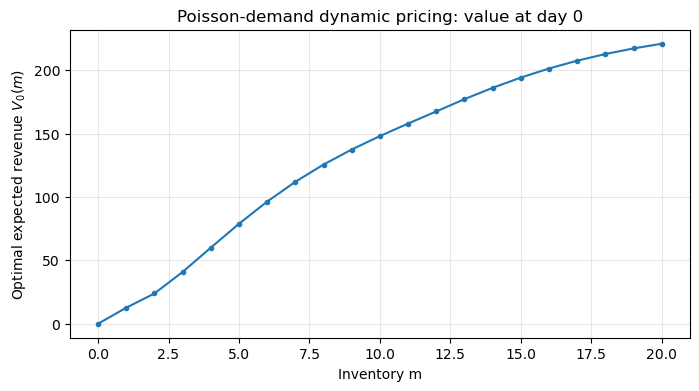

In [7]:
# --- Q3(C): Poisson-demand dynamic pricing (solve_dynamic_pricing + demo) ---

from typing import Sequence, Tuple
from math import exp

def poisson_pmf(lam: float, k_max: int) -> list:
    """Poisson(lam) pmf for k=0..k_max using iterative recurrence pmf(0)=exp(-lam), pmf(k+1)=pmf(k)*lam/(k+1)."""
    pmf = [exp(-lam)]
    for k in range(1, k_max + 1):
        pmf.append(pmf[-1] * lam / k)
    return pmf

def solve_dynamic_pricing(
    T: int,
    M: int,
    prices: Sequence[float],
    lambdas: Sequence[float],
) -> Tuple[list, list]:
    """
    Backward induction for Poisson-demand dynamic pricing.
    State: (t, m) = day index t (0..T-1), masks m (0..M). V[T, m]=0.
    Sales = min(m, demand), revenue = price * sales.
    Returns:
        V: list of length T+1, V[t][m] = value at day t with m masks
        Policy: list of length T+1, Policy[t][m] = optimal price index (0-based)
    """
    N = len(prices)
    V = [[0.0] * (M + 1) for _ in range(T + 1)]
    Policy = [[0] * (M + 1) for _ in range(T + 1)]

    for t in range(T - 1, -1, -1):
        for m in range(1, M + 1):
            best_val = -1.0
            best_i = 0
            for i in range(N):
                lam = lambdas[i]
                p_i = prices[i]
                pmf = poisson_pmf(lam, m)
                tail = 1.0 - sum(pmf)
                ev = 0.0
                for k in range(m):
                    sales = k
                    rem = m - sales
                    ev += pmf[k] * (p_i * sales + V[t + 1][rem])
                ev += tail * (p_i * m + V[t + 1][0])
                if ev > best_val:
                    best_val = ev
                    best_i = i
            V[t][m] = best_val
            Policy[t][m] = best_i

    return V, Policy

# Demo
T_demo, M_demo = 5, 20
prices_demo = [10.0, 15.0, 20.0]
lambdas_demo = [5.0, 3.0, 1.5]

V_dp, Policy_dp = solve_dynamic_pricing(T_demo, M_demo, prices_demo, lambdas_demo)

print(f"Optimal expected revenue from day 0 with {M_demo} masks: ${V_dp[0][M_demo]:.2f}")
print("\nOptimal price index (0/1/2) on day 0 for selected inventory levels:")
for m in [M_demo, M_demo//2, M_demo//4, 5, 1]:
    idx = Policy_dp[0][m]
    print(f"  m={m:2d}: price ${prices_demo[idx]:.2f} (index {idx})")

# Small table slice: first 3 days, inventory 1..5
print("\nPolicy slice (days 0,1,2 × inventory 1..5):")
for t in range(min(3, T_demo)):
    row = [Policy_dp[t][m] for m in range(1, 6)]
    print(f"  t={t}: {row}")

# Plot value vs inventory for day 0
plt.figure(figsize=(8, 4))
plt.plot(range(M_demo + 1), V_dp[0], marker="o", markersize=3)
plt.xlabel("Inventory m")
plt.ylabel("Optimal expected revenue $V_0(m)$")
plt.title("Poisson-demand dynamic pricing: value at day 0")
plt.grid(True, alpha=0.3)
plt.show()


## Question 4: Risk-Aversion and Utility Optimization under CARA Utility (Led by Onat Dalmaz)

You are tasked with analyzing the behavior of an investor who seeks to maximize their utility under **CARA Utility**. The investor has wealth $W$ and the CARA utility function:

$$
U(W) = \frac{1 - e^{-aW}}{a}, \quad a > 0,
$$

where $a$ represents the investor's **risk aversion**.

The investor allocates their wealth between:
1. A **riskless asset** with a fixed return $r$, and
2. A **risky asset** with return $R \sim \mathcal{N}(\mu, \sigma^2)$

The investor allocates a fraction $\pi$ of their wealth to the risky asset and $(1 - \pi)$ to the riskless asset. The wealth $W$ after one year is given by:

$$
W = (1 + r)(1 - \pi) + (1 + R)\pi.
$$

The goal is to analyze the investor’s optimal allocation $\pi$ to the risky asset and compute key risk-related quantities.

---

### Subquestions

#### Part (A): Expected Utility and Certainty-Equivalent Wealth

1. Derive the expression for the **expected utility** $\mathbb{E}[U(W)]$, using the given CARA utility function and assuming $R \sim \mathcal{N}(\mu, \sigma^2)$.
2. Using a Taylor expansion, approximate the **certainty-equivalent wealth** $W_{CE}$ up to second-order terms.

---

#### Part (B): Optimal Portfolio Allocation

Derive the optimal fraction $\pi^*$ of wealth to be allocated to the risky asset such that the **expected utility** $\mathbb{E}[U(W)]$ is maximized. Express $\pi^*$ in terms of $a$, $\mu$, $r$, and $\sigma^2$.

---

#### Part (C): Risk Premium

1. Using the results from Part (A), calculate the **absolute risk premium** $\pi_A = \mathbb{E}[W] - W_{CE}$.
2. Verify that $\pi_A \approx \frac{a \pi^2 \sigma^2}{2}$ for small $\sigma^2$.

---

#### Part (D): Numerical Calculations and Interpretation

Given the parameters $r = 0.02$, $\mu = 0.08$, $\sigma^2 = 0.04$, and $a = 3$:
1. Compute the optimal allocation $\pi^*$.
2. Calculate the certainty-equivalent wealth $W_{CE}$.
3. Compute the absolute risk premium $\pi_A$.
4. Interpret the results and discuss how changes in $a$ and $\sigma^2$ affect the risk premium and portfolio allocation.

---

#### Part (E): Expected Utility under Uniform Distribution

Now assume that the return of the risky asset, $R$, is no longer normally distributed. Instead, $R \sim \text{Uniform}[\alpha, \beta]$, where $\alpha$ and $\beta$ are the lower and upper bounds of the distribution, respectively.

1. Derive the new expression for the **expected utility** $\mathbb{E}[U(W)]$. Make sure to simplify your result as much as possible, and ensure that it explicitly depends on $a$, $\pi$, $\alpha$, $\beta$, and $r$.

**Hint**: Use the fact that if $W \sim \text{Uniform}[w_{\text{min}}, w_{\text{max}}]$, then:

$$
\mathbb{E}[g(W)] = \frac{1}{w_{\text{max}} - w_{\text{min}}} \int_{w_{\text{min}}}^{w_{\text{max}}} g(W) \, dW.
$$

---

### Part (A) Answer

Write wealth as
$$
W=(1+r)(1-\pi)+(1+R)\pi=(1+r)+\pi(R-r).
$$
With CARA utility $U(W)=\frac{1-e^{-aW}}{a}$,
$$
\mathbb E[U(W)] = \frac{1-\mathbb E[e^{-aW}]}{a}.
$$

If $R\sim\mathcal N(\mu,\sigma^2)$ then $R-r\sim\mathcal N(\mu-r,\sigma^2)$ and
$$
\mathbb E[e^{-aW}]
= e^{-a(1+r)}\,\mathbb E\!\left[e^{-a\pi(R-r)}\right]
= e^{-a(1+r)}\exp\!\left(-a\pi(\mu-r)+\frac{a^2\pi^2\sigma^2}{2}\right).
$$
Therefore
$$
\boxed{\ \mathbb E[U(W)] = \frac{1}{a}\left(1-\exp\!\left[-a(1+r)-a\pi(\mu-r)+\frac{a^2\pi^2\sigma^2}{2}\right]\right)\ }.
$$

**Certainty equivalent.** $W_{CE}$ solves $U(W_{CE})=\mathbb E[U(W)]$, i.e.
$e^{-aW_{CE}}=\mathbb E[e^{-aW}]$, so
$$
W_{CE}=-\frac{1}{a}\log\mathbb E[e^{-aW}]
=(1+r)+\pi(\mu-r)-\frac{a\pi^2\sigma^2}{2}.
$$

If you *Taylor-expand* around small variance, this matches
$$
\boxed{\ W_{CE}\approx \mathbb E[W]-\frac{a}{2}\mathrm{Var}(W)\ }
$$
since $\mathbb E[W]=(1+r)+\pi(\mu-r)$ and $\mathrm{Var}(W)=\pi^2\sigma^2$.


### Part (B) Answer

Because CARA utility is strictly increasing, maximizing $\mathbb E[U(W)]$ is equivalent to maximizing $W_{CE}$:
$$
W_{CE}(\pi)=(1+r)+\pi(\mu-r)-\frac{a\pi^2\sigma^2}{2}.
$$
This is a concave quadratic in $\pi$. Set derivative to zero:
$$
\frac{dW_{CE}}{d\pi}=(\mu-r)-a\pi\sigma^2=0
\quad\Rightarrow\quad
\boxed{\ \pi^\star=\frac{\mu-r}{a\sigma^2}\ }.
$$
(If you impose constraints like $\pi\in[0,1]$, you’d clip this to the interval.)


### Part (C) Answer

Absolute risk premium:
$$
\pi_A=\mathbb E[W]-W_{CE}.
$$
Using $\mathbb E[W]=(1+r)+\pi(\mu-r)$ and $W_{CE}=(1+r)+\pi(\mu-r)-\frac{a\pi^2\sigma^2}{2}$,
$$
\boxed{\ \pi_A=\frac{a\pi^2\sigma^2}{2}\ }.
$$

So (and in fact, exactly under normality + CARA) for small $\sigma^2$,
$$
\pi_A \approx \frac{a\pi^2\sigma^2}{2}.
$$


### Part (D) Answer

Given $r=0.02$, $\mu=0.08$, $\sigma^2=0.04$, $a=3$:

1) Optimal allocation:
$$
\pi^\star=\frac{\mu-r}{a\sigma^2}=\frac{0.06}{3\cdot 0.04}=0.5.
$$

2) Certainty-equivalent wealth:
$$
\mathbb E[W]=(1+r)+\pi^\star(\mu-r)=1.02+0.5\cdot 0.06=1.05,
$$
$$
W_{CE}= \mathbb E[W]-\frac{a(\pi^\star)^2\sigma^2}{2}
=1.05-\frac{3\cdot 0.25\cdot 0.04}{2}
=1.05-0.015
=1.035.
$$

3) Absolute risk premium:
$$
\pi_A=\mathbb E[W]-W_{CE}=0.015.
$$

4) Interpretation:
- Increasing **risk aversion $a$** or **variance $\sigma^2$** lowers $\pi^\star$ (you take less risk).
- For a *fixed* $\pi$, the risk premium scales like $\frac{a\pi^2\sigma^2}{2}$, so it increases with both $a$ and $\sigma^2$.
- At the **optimal** $\pi^\star$, the premium becomes
  $$\pi_A(\pi^\star)=\frac{(\mu-r)^2}{2a\sigma^2},$$
  which decreases with $a$ and increases when the Sharpe-like ratio $(\mu-r)/\sigma$ increases.


In [8]:
# Q4 Part (D): Numerical calculations (r=0.02, μ=0.08, σ²=0.04, a=3)
r, mu, var, a = 0.02, 0.08, 0.04, 3
pi_star = (mu - r) / (a * var)
E_W = (1 + r) + pi_star * (mu - r)
W_CE = E_W - (a * pi_star**2 * var) / 2
pi_A = E_W - W_CE
print(f"π* = {pi_star:.4f}")
print(f"E[W] = {E_W:.4f}")
print(f"W_CE = {W_CE:.4f}")
print(f"π_A = {pi_A:.4f}")

π* = 0.5000
E[W] = 1.0500
W_CE = 1.0350
π_A = 0.0150


### Part (E) Answer

Now $R\sim \mathrm{Uniform}[\alpha,\beta]$ and
$$
W=(1+r)+\pi(R-r).
$$
Then
$$
\mathbb E[U(W)] = \frac{1-\mathbb E[e^{-aW}]}{a},
\quad
\mathbb E[e^{-aW}]
= \frac{1}{\beta-\alpha}\int_{\alpha}^{\beta}
\exp\big(-a[(1+r)+\pi(x-r)]\big)\,dx.
$$
Pull out constants:
$$
\mathbb E[e^{-aW}]
= e^{-a(1+r)}\cdot \frac{1}{\beta-\alpha}\int_{\alpha}^{\beta} e^{-a\pi(x-r)}\,dx.
$$

If $\pi\neq 0$:
$$
\int_{\alpha}^{\beta} e^{-a\pi(x-r)}\,dx
= \frac{e^{-a\pi(\alpha-r)}-e^{-a\pi(\beta-r)}}{a\pi}.
$$
So
$$
\boxed{\ 
\mathbb E[U(W)] =
\frac{1}{a}\left[
1-
e^{-a(1+r)}
\frac{e^{-a\pi(\alpha-r)}-e^{-a\pi(\beta-r)}}{(\beta-\alpha)\,a\pi}
\right]\ }.
$$

If $\pi=0$, then $W=1+r$ deterministically and $\mathbb E[U(W)]=U(1+r)=\\frac{1-e^{-a(1+r)}}{a}$.
